# New evaluation test set playground

In [105]:
import os
import numpy as np
import json
import pandas as pd
from birdnetlib.analyzer import Analyzer
from birdnetlib.batch import DirectoryAnalyzer
import matplotlib.pyplot as plt 

## test the model and extract predictions

In [93]:
# E:\Giacomo\Tovanella-20241110T120546Z-001\training_sessions\session_0\test\Certhia familiaris_Eurasian Treecreeper\20200217_160000_591.wav
# salva tutti i risultati su questo array
complete_pred_segments = {}
def on_analyze_complete(recording):
    # E:\Giacomo\Tovanella-20241110T120546Z-001\test_set_augm\test\Periparus ater_Coal Tit\20200215_090000_88.wav
    audio_name = recording.path.split('\\')[-1]
    date, number, segm_id = audio_name.split('_')    # <20200215>_<090000>_<88.wav>
    segm_id = segm_id.split('.')[0]               # <88>.<wav>
    audio_name = "_".join([date, number]) + ".WAV"      # 20200215_090000.WAV
    if audio_name not in complete_pred_segments:
        complete_pred_segments[audio_name] = {}
    if segm_id not in complete_pred_segments[audio_name]:
        complete_pred_segments[audio_name][segm_id] = {}
    complete_pred_segments[audio_name][segm_id] = { detection["label"]: detection["confidence"] for detection in recording.detections}
    print("Analyzing ", recording.path)

def on_error(recording, error):
    print("An exception occurred: {}".format(error))
    print(recording.path)

In [94]:
pred_segments = {}
model_path = "classifiers\\new_segments\\CustomClassifier.tflite"
labels_path = "classifiers\\new_segments\\CustomClassifier_Labels.txt"
audio_path = "E:\\Giacomo\\Tovanella-20241110T120546Z-001\\test_set_augm\\test"
analyzer = Analyzer(
    classifier_labels_path=labels_path, 
    classifier_model_path=model_path,
)      

for folder in os.listdir(audio_path):
    directory = os.path.join(audio_path, folder)

    print("Starting Watcher: ", folder)
    batch = DirectoryAnalyzer(
        directory,
        analyzers=[analyzer],
        min_conf=0.25,
    )

    batch.on_analyze_complete = on_analyze_complete
    batch.on_error = on_error
    batch.process()

load_custom_models
Custom model loaded.
loading custom classifier labels
Labels loaded.
load model False
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
Starting Watcher:  Certhia familiaris_Eurasian Treecreeper
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190621_170000_10.wav
Analyzing  E:\Giacomo\Tovanella-20241110T120546Z-001\test_set_augm\test\Certhia familiaris_Eurasian Treecreeper\20190621_170000_10.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190621_170000_15.wav
Analyzing  E:\Giacomo\Tovanella-20241110T120546Z-001\test_set_augm\test\Certhia familiaris_Eurasian Treecreeper\20190621_170000_15.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190621_170000_17.wav
Analyzing  E:\Giacomo\Tovanella-20241110T120546Z-001\test_set_augm\test\Certhia familiaris_Eurasian Treecreeper\20190621_170000_17.wav
read_audio_data
read_audio_data: complete, read  1 chunks.


In [95]:
# with open("utils/complete_pred_segments.json", "w") as f:
#     json.dump(complete_pred_segments, f)

## extract predicted and true segments 

In [96]:
with open("utils/complete_pred_segments.json") as f:
    complete_pred_segments = json.load(f)

In [97]:
pred_segments = {audio: { 
        key: list(value.keys()) for key, value in complete_pred_segments[audio].items()
    } for audio in complete_pred_segments.keys() }
pred_segments["20200215_110000.WAV"]

{'67': ['Wind_'], '68': ['Wind_'], '69': ['Wind_'], '70': ['Vegetation_']}

In [98]:
with open("utils/true_segments.json") as f:
    all_segments = json.load(f)
# filter segments in true_segments from the ones not present in pred
true_segments = {audio: { 
        key: value for key, value in all_segments[audio].items() if key in pred_segments[audio]
    } for audio in all_segments.keys() if audio in pred_segments}
true_segments["20200215_110000.WAV"]

{'67': ['Wind_'], '68': ['Wind_'], '69': ['Wind_'], '70': ['Wind_']}

## get results

In [99]:
from sklearn.preprocessing import MultiLabelBinarizer

species_list = os.listdir(audio_path)

mlb = MultiLabelBinarizer()
mlb.fit([list(species_list)])

len(mlb.classes_)

19

### side quest: get confidence scores for each label

In [100]:
conf_scores = { specie: [] for specie in species_list }
for audio in pred_segments:
    for segm, species in pred_segments[audio].items():
        for specie in species:
            if specie not in species_list:
                continue
            conf_scores[specie].append([complete_pred_segments[audio][segm][specie], specie in true_segments[audio][segm]])
conf_scores["Dendrocopos major_Great Spotted Woodpecker"]

[[0.9670880436897278, True],
 [0.9595276117324829, True],
 [0.6463632583618164, True],
 [0.9791899919509888, True],
 [0.8687033653259277, True],
 [0.794307291507721, True]]

In [101]:
with open("utils/conf_scores.json", "w") as f:
    json.dump(conf_scores, f)

In [131]:
complete_pred_segments["20190621_170000.WAV"]["10"].keys()

dict_keys(['Regulus ignicapilla_Common Firecrest', 'Sylvia atricapilla_Eurasian Blackcap'])

### classification report

In [ ]:
y_pred = []
y_true = []
for audio in pred_segments:
    # sort in increasing order
    sortable_true_segments = { int(key): value for key, value in true_segments[audio].items() }
    sortable_pred_segments = { int(key): value for key, value in pred_segments[audio].items() }
    sorted_true_segments = dict(sorted(sortable_true_segments.items()))
    sorted_pred_segments = dict(sorted(sortable_pred_segments.items()))
    y_true.append(mlb.transform(sorted_true_segments.values()))     # apply transform on every label of every segment
    y_pred.append(mlb.transform(sorted_pred_segments.values()))     # apply transform on every label of every segment

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Phylloscopus collybita_Common Chiffchaff'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Ficedula parva_Red-breasted Flycatcher', 'Phylloscopus collybita_Common Chiffchaff'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Dendrocopos leucotos_White-backed Woodpecker', 'Tyto alba_Barn Owl'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Picus canus_Gray-headed Woodpecker', 'Picus viridis_Eurasian Green Woodpecker'] will be ignored
  warnings.warn(
c:\Users\giaco\AppD

In [220]:
len(y_true)

719

In [231]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
# apply colors
# add index column name to df
report_df = pd.DataFrame(report).T
report_df

,precision,recall,f1-score,support
Certhia familiaris_Eurasian Treecreeper,1.000000,0.086957,0.160000,23.0
Dendrocopos major_Great Spotted Woodpecker,1.000000,0.400000,0.571429,15.0
Dryocopus martius_Black Woodpecker,1.000000,0.100000,0.181818,10.0
Erithacus rubecula_European Robin,0.666667,0.400000,0.500000,25.0
Fringilla coelebs_Common Chaffinch,0.402145,0.704225,0.511945,213.0
Lophophanes cristatus_Crested Tit,0.000000,0.000000,0.000000,6.0
Loxia curvirostra_Common Crossbill,0.421053,0.592593,0.492308,27.0
Muscicapa striata_Spotted Flycatcher,0.000000,0.000000,0.000000,2.0
Pecking_,0.214286,0.692308,0.327273,13.0
Periparus ater_Coal Tit,0.600000,0.210526,0.311688,57.0


### auc roc

In [254]:
y_pred_conf = []

for audio in pred_segments:
    scores_pred = []
    for segm, predictions in complete_pred_segments[audio].items():
        segm_conf_score = np.zeros(len(mlb.classes_))  # Vettore inizializzato a 0 per tutte le classi

        for pred, conf in predictions.items():
            binary_vector = mlb.transform([[pred]])[0]  # Convertiamo in binario (shape: (n_classes,))
            segm_conf_score += binary_vector * conf  # Moltiplichiamo per il confidence score

        scores_pred.append(segm_conf_score)  # Ogni segmento ora ha un array della stessa lunghezza di n_classes
    
    y_pred_conf.append(np.array(scores_pred))  # Lista di array uniformi

# Convertiamo in un array 2D
y_pred_conf = np.vstack(y_pred_conf)

# Output della shape per verifica
print("y_pred_conf shape:", y_pred_conf.shape)


y_pred_conf shape: (719, 19)


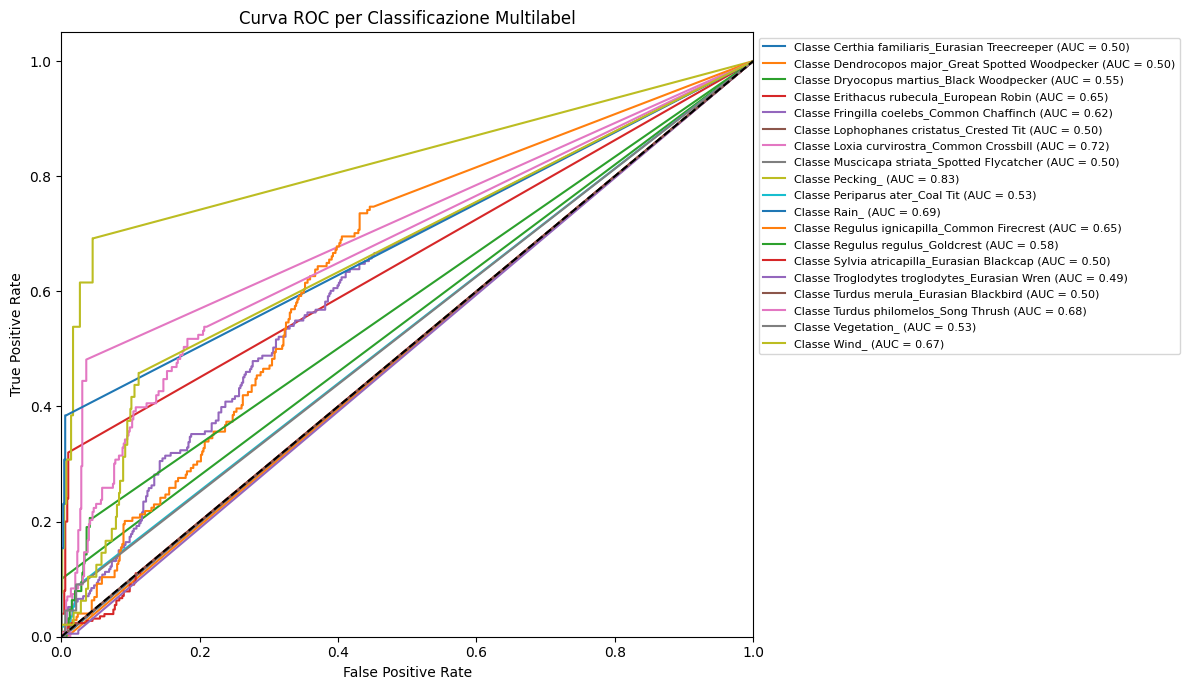

In [267]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 7))  # Aumenta la dimensione
n_classes = len(mlb.classes_)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_conf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {mlb.classes_[i]} (AUC = {roc_auc:.2f})')

# Linea di riferimento
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC per Classificazione Multilabel')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.show()